In [36]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import sklearn
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as metrics

In [2]:
seed = 0
np.random.seed(seed)

## Linear kernel

In [37]:
X, y = ds.make_blobs(n_samples=7000, random_state=seed, centers=2)
y = np.where(y==0, -1, y)

In [38]:
print(X.shape, y.shape)

(7000, 2) (7000,)


In [39]:
y = y.reshape(-1,1)

In [40]:
y.shape

(7000, 1)

In [41]:
X_pos = X[[np.where(y==-1)[0]], :].squeeze()
X_neg = X[[np.where(y==1)[0]], :].squeeze()

In [42]:
print(X_pos.shape, X_neg.shape)

(3500, 2) (3500, 2)


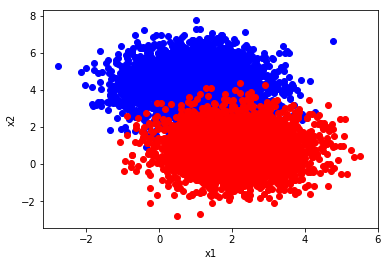

In [43]:
fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.scatter(X_pos[:,0], X_pos[:,1], c='blue')
ax0.scatter(X_neg[:,0], X_neg[:,1], c='red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [44]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y            
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [46]:
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [47]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(5600, 2) (5600, 1) (700, 2) (700, 1) (700, 2) (700, 1)


In [48]:
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_valid, y_valid)
test_ds = Dataset(X_test, y_test)

In [90]:
n_iter = 10000
batch_size = 128
n_epochs = int(n_iter / (len(train_ds) / batch_size))
print(n_epochs)

228


In [50]:
train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=batch_size)
valid_loader = data.DataLoader(valid_ds, shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(test_ds, shuffle=False, batch_size=batch_size)

In [79]:
class LinearSVM(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(LinearSVM, self).__init__()
        # using a linear kernel: wx + b, where w and b are the parameters of the hyperplane
        self.linear = nn.Linear(input_dim, out_dim)
    def forward(self, X):
        out = self.linear(X)
        return out

### Hinge Loss
$\ell(y) = \max(0, 1-t \cdot y)$

where $t=\pm 1$ and $y$ is the kernel. In linear SVM, $y = \mathbf{w} \cdot \mathbf{x} + b$, where $(\mathbf{w},b)$ are the parameters of the hyperplane and $ \mathbf {x}$  is the point to classify.

Read more [here](https://en.wikipedia.org/wiki/Hinge_loss)

In [101]:
def train(model, optimizer, n_epochs, reg_lambda=1e-2):
    train_loss = []
    count = 0
    for epoch in range(n_epochs):
        for itr, (X, t) in enumerate(train_loader):
            X = Variable(X.float(), requires_grad=False)
            t = Variable(t.float(), requires_grad=False)

            y = model(X)

            # Hinge loss
            loss = torch.mean(torch.clamp(1 - t * y, min=0))
            # L2 regularization
            l2 = 0
            for layer in model.children():
                l2 += torch.mean(layer.weight ** 2)
            loss += reg_lambda * l2
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            count += 1

            if count % 500 == 0:
                acc_aggr = []
                for X, y in valid_loader:
                    X = Variable(X.float(), requires_grad=False)
                    y = y.numpy()
                    y = np.where(y < 1, 0, y)
                    out = model(X).detach().numpy()
                    out = np.where(out >= 1, 1, 0)
                    acc = metrics.roc_auc_score(y, out)
                    acc_aggr.append(acc)
                print("iter:{}, loss={}, accuracy={}".format(count, loss.item(), np.mean(acc_aggr)))
    return train_loss

In [102]:
lin_svm = LinearSVM(2, 1)
optimizer = torch.optim.SGD(lin_svm.parameters(), lr=0.1)
trloss = train(lin_svm, optimizer, n_epochs, reg_lambda=0.00001)

iter:500, loss=0.07805569469928741, accuracy=0.9187418937656938
iter:1000, loss=0.09051475673913956, accuracy=0.9430100786798676
iter:1500, loss=0.12006961554288864, accuracy=0.9472201259194523
iter:2000, loss=0.1037302315235138, accuracy=0.9472201259194523
iter:2500, loss=0.08515136688947678, accuracy=0.9472201259194523
iter:3000, loss=0.11836020648479462, accuracy=0.951498399728976
iter:3500, loss=0.09096729755401611, accuracy=0.9526888759194522
iter:4000, loss=0.07078149169683456, accuracy=0.9526888759194522
iter:4500, loss=0.08874477446079254, accuracy=0.9526888759194522
iter:5000, loss=0.08992171287536621, accuracy=0.9526888759194522
iter:5500, loss=0.06919805705547333, accuracy=0.9526888759194522
iter:6000, loss=0.06452804803848267, accuracy=0.9526888759194522
iter:6500, loss=0.10050094127655029, accuracy=0.9526888759194522
iter:7000, loss=0.06103568524122238, accuracy=0.9556650663956426
iter:7500, loss=0.13112832605838776, accuracy=0.9497126854432617
iter:8000, loss=0.0544638000

In [103]:
parameters = list(lin_svm.parameters())
for i in range(len(parameters)):
    print(parameters[i].data)

tensor([[ 0.6082, -1.9272]])
tensor([4.1226])


In [106]:
test_out = lin_svm(Variable(torch.FloatTensor(test_ds.X))).detach().numpy()

In [107]:
test_out.shape

(700, 1)

In [108]:
y_pred = test_out.copy()
y_pred = np.where(y_pred >= 1, 1, 0)
y_true = np.where(y_test >= 1, 1, 0)
fpr, tpr, thr = metrics.roc_curve(y_true, y_pred)

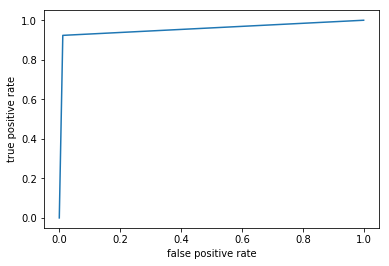

In [116]:
plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [110]:
metrics.roc_auc_score(y_true, y_pred)

0.9559926851768702

In [117]:
test_out.shape

(700, 1)

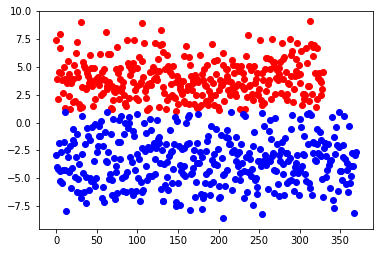

In [123]:
y_pos = test_out[[np.where(test_out >= 1)[0]], :].squeeze()
y_neg = test_out[[np.where(test_out < 1)[0]], :].squeeze()
x_pos = np.arange(0, y_pos.shape[0], 1)
x_neg = np.arange(0, y_neg.shape[0], 1)
fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.scatter(x_pos, y_pos, c='red')
ax0.scatter(x_neg, y_neg, c='blue')
plt.show()